In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import json
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
rcParams['axes.titlesize'] = 'large'
rcParams['figure.autolayout'] = True

In [58]:
train_data = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test_data = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')

In [3]:
movies = pd.concat([train_data, test_data], sort=False)

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 0 to 4397
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7398 non-null   int64  
 1   belongs_to_collection  1481 non-null   object 
 2   budget                 7398 non-null   int64  
 3   genres                 7375 non-null   object 
 4   homepage               2366 non-null   object 
 5   imdb_id                7398 non-null   object 
 6   original_language      7398 non-null   object 
 7   original_title         7398 non-null   object 
 8   overview               7376 non-null   object 
 9   popularity             7398 non-null   float64
 10  poster_path            7396 non-null   object 
 11  production_companies   6984 non-null   object 
 12  production_countries   7241 non-null   object 
 13  release_date           7397 non-null   object 
 14  runtime                7392 non-null   float64
 15  spok

In [2]:
movies = pd.read_csv('../input/movies-backup-1/movies_backup (1).csv')

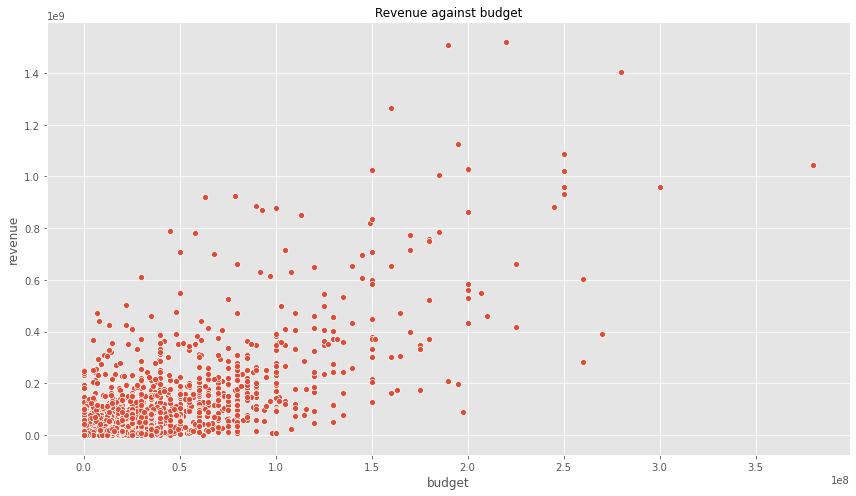

In [6]:
sns.scatterplot(movies.budget, movies.revenue)
plt.title('Revenue against budget')
plt.show()

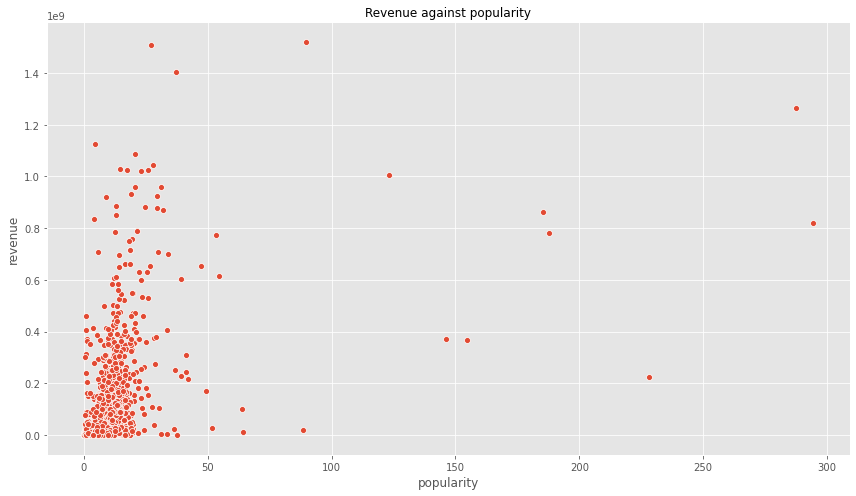

In [7]:
sns.scatterplot(movies.popularity, movies.revenue)
plt.title('Revenue against popularity')
plt.show()

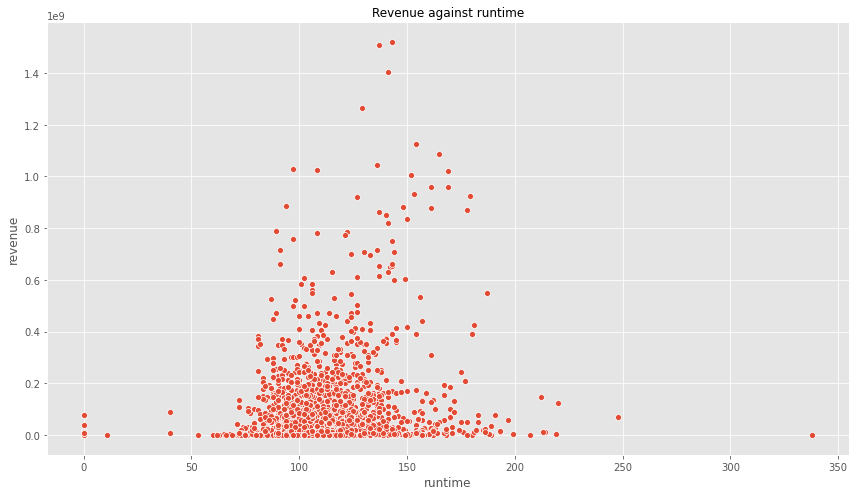

In [8]:
sns.scatterplot(movies.runtime, movies.revenue)
plt.title('Revenue against runtime')
plt.show()

Выделим жанры из стобца genres и закодируем в формате one-hot-encoding:

In [21]:
movies['genres'] = movies['genres'].apply(lambda x: ', '.join(sorted(name['name'] for name in eval(x))))
movies_genres = movies.genres.str.get_dummies(sep=', ')

In [22]:
movies = pd.concat([movies, movies_genres], axis=1)

In [23]:
movies.drop(columns=['genres'], inplace=True)

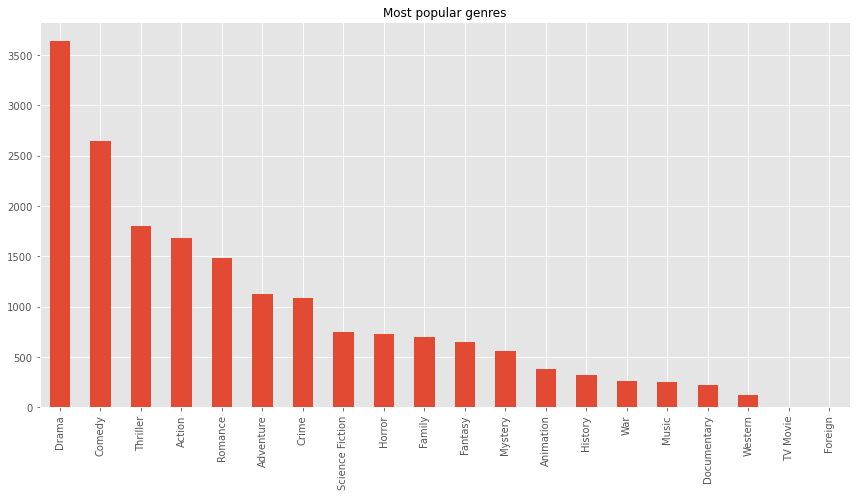

In [24]:
movies_genres.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Most popular genres')
plt.show()

Сделаем бинарный признак на основе языка фильма "фильм на английском или нет", т.к. присутствует явный дисбаланс и множество признаков практически равны нулю:

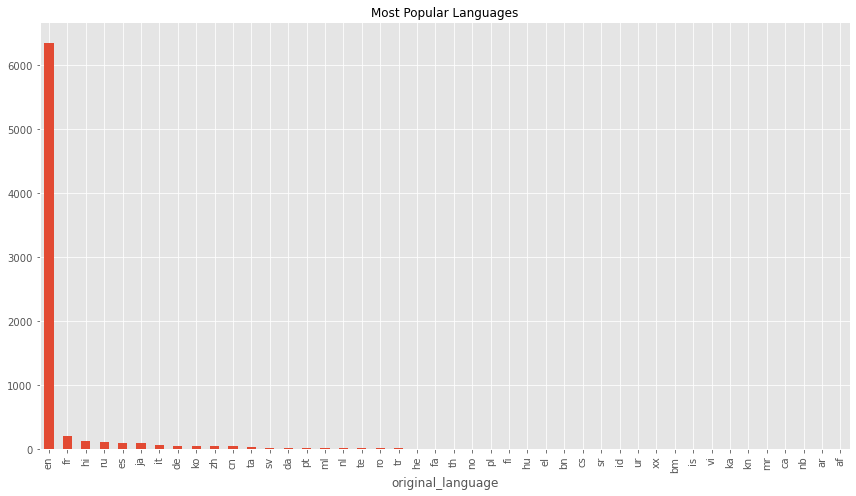

In [25]:
movies.groupby('original_language').id.count().sort_values(ascending=False).plot(kind='bar')
plt.title('Most Popular Languages')
plt.show()

In [26]:
movies['original_language']

0       en
1       en
2       en
3       hi
4       ko
        ..
7393    en
7394    en
7395    en
7396    en
7397    fr
Name: original_language, Length: 7398, dtype: object

In [27]:
movies_original_language = pd.get_dummies(movies['original_language'], columns=['original_language'])

In [28]:
best_orig_lang = movies_original_language.sum().sort_values(ascending=False).head(25).index.tolist()

In [29]:
movies_original_language = movies_original_language[best_orig_lang]

In [30]:
rename_orig_lang = {name: name + '_orig_language' for name in movies_original_language.columns}
movies_original_language.rename(columns=rename_orig_lang, inplace=True)

In [31]:
movies_original_language

,en_orig_language,fr_orig_language,hi_orig_language,ru_orig_language,es_orig_language,ja_orig_language,it_orig_language,de_orig_language,ko_orig_language,zh_orig_language,...,ml_orig_language,nl_orig_language,te_orig_language,ro_orig_language,tr_orig_language,he_orig_language,fa_orig_language,th_orig_language,no_orig_language,pl_orig_language
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7394,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7395,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7396,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
movies.index = movies_original_language.index
movies = pd.concat([movies_original_language, movies], axis=1)
lang_replace = {lang: ('en' if lang == 'en' else 'other') for lang in movies.original_language.unique()}
movies['en_language'] = movies.original_language.map(lang_replace)

In [33]:
movies.en_language = movies.en_language.map({'en': 1, 'other': '0'})
movies.en_language = movies.en_language.astype('int64')

In [34]:
movies.drop(columns=['en_language', 'Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

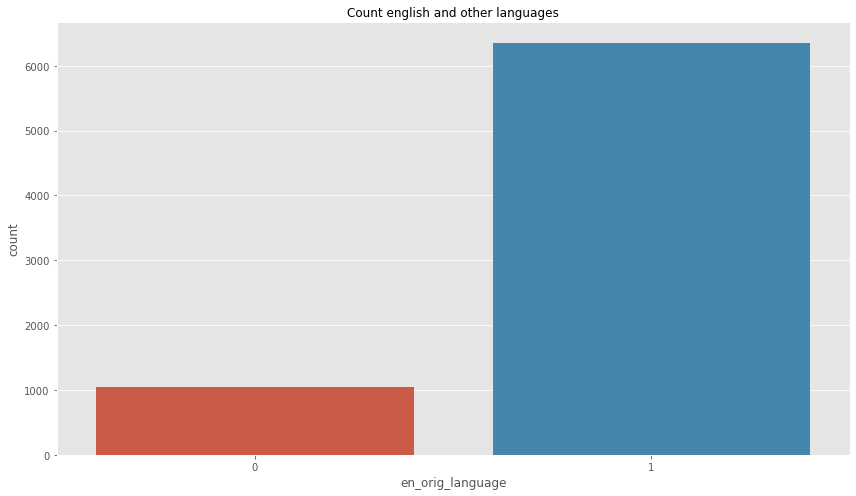

In [37]:
sns.countplot(movies.en_orig_language)
plt.title('Count english and other languages')
plt.show()

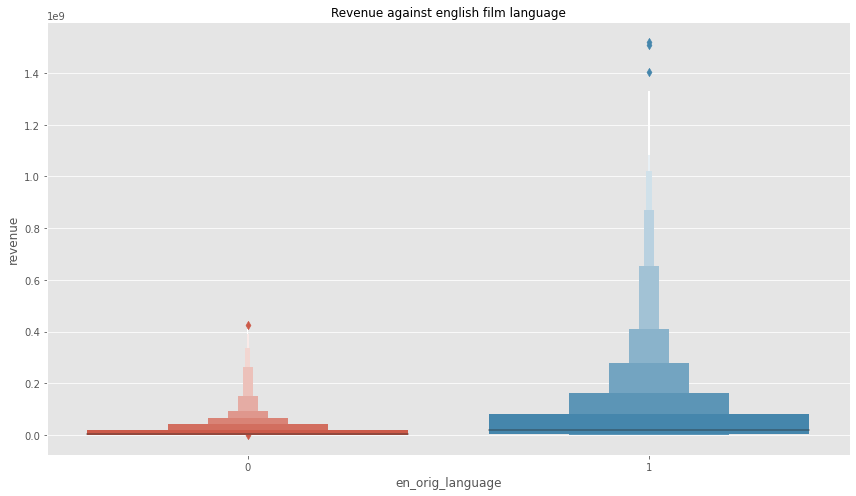

In [40]:
sns.boxenplot(x=movies.en_orig_language, y=movies.revenue)
plt.title('Revenue against english film language')
plt.show()

Добавим признак: длина заголовка.

In [41]:
movies['len_title'] = movies.original_title.apply(lambda x: len(x))

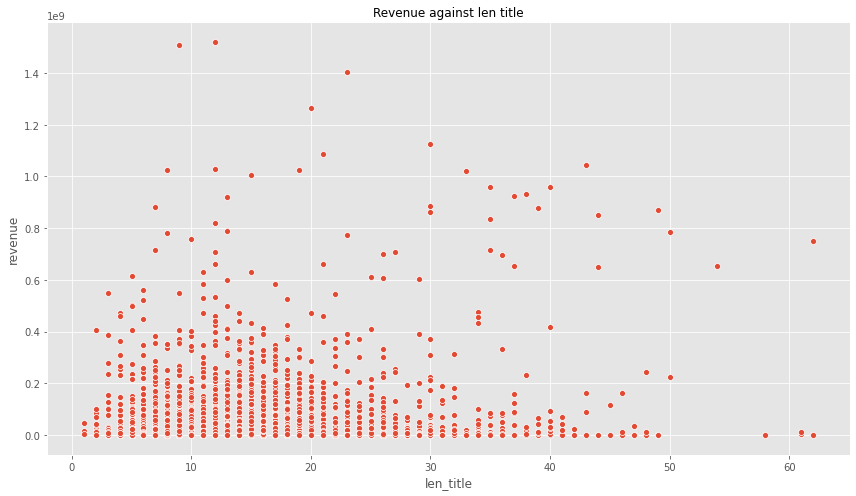

In [42]:
sns.scatterplot(movies.len_title, movies.revenue)
plt.title('Revenue against len title')
plt.show()

Посмотрим на null-ы, их много, попробуем допарсить информацию с сайта https://api.themoviedb.org через их API:

In [44]:
movies.isnull().sum().sort_values(ascending=False).head(50)

homepage                 4950
revenue                  4398
tagline                  1248
Keywords                  484
production_companies      241
production_country         95
overview                   12
budget                      0
th_orig_language            0
no_orig_language            0
pl_orig_language            0
id                          0
belongs_to_collection       0
original_language           0
imdb_id                     0
spoken_languages            0
original_title              0
popularity                  0
release_date                0
runtime                     0
fa_orig_language            0
len_title                   0
tr_orig_language            0
ro_orig_language            0
fr_orig_language            0
hi_orig_language            0
ru_orig_language            0
es_orig_language            0
ja_orig_language            0
it_orig_language            0
de_orig_language            0
ko_orig_language            0
zh_orig_language            0
cn_orig_la

Доставим в ручную данные в столбцах, в которых небольшое количество пропусков:

In [45]:
movies.loc[movies.id == 1336, 'runtime'] = 130.0
movies.loc[movies.id == 2303, 'runtime'] = train_data.runtime.median()
movies.loc[movies.id == 3244, 'runtime'] = 93.0
movies.loc[movies.id == 4490, 'runtime'] = 91.0
movies.loc[movies.id == 4633, 'runtime'] = 100.0
movies.loc[movies.id == 6818, 'runtime'] = 90.0

movies.loc[movies.id == 3829, 'release_date'] = '03/20/01'

movies.loc[movies.id == 5399, 'title'] = movies.loc[movies.id == 5399, 'original_title']
movies.loc[movies.id == 5426, 'title'] = movies.loc[movies.id == 5426, 'original_title']
movies.loc[movies.id == 6629, 'title'] = movies.loc[movies.id == 6629, 'original_title']

In [ ]:
movies.drop(columns=['poster_path', 'status'], inplace=True)

In [47]:
movies.isnull().sum().sort_values(ascending=False)

homepage                4950
revenue                 4398
tagline                 1248
Keywords                 484
production_companies     241
                        ... 
quarter                    0
year_of_release            0
vote_count                 0
vote_average               0
en_orig_language           0
Length: 80, dtype: int64

Следующим скриптом допарсим пропуски в части колонок, которые доступны по одному адресу API:

In [ ]:
null_prod_companies_id = movies.loc[(movies.production_companies.isnull()) 
    | (movies.production_countries.isnull())
    | (movies.homepage.isnull())
    | (movies.overview.isnull())
    | (movies.genres.isnull())
    | (movies.spoken_languages.isnull())
    | (movies.tagline.isnull())
    | (movies.belongs_to_collection.isnull()), 'id'].values

In [ ]:
for id in null_prod_companies_id:
    imdb_id = movies.loc[movies['id'] == id, 'imdb_id'].tolist()[0]
    r = requests.get(
        f'https://api.themoviedb.org/3/find/{imdb_id}?api_key=3a5b6ff6e451eab663db147a3b5c6477&language=en-US&external_source=imdb_id')
    if r.ok:
        check = json.loads(r.content)['movie_results']
        if check:
            film_id = json.loads(r.content)['movie_results'][0]['id']
            if film_id:
                r = requests.get(
                    f'https://api.themoviedb.org/3/movie/{film_id}?api_key=3a5b6ff6e451eab663db147a3b5c6477&language=en-US')
                film_info = json.loads(r.content)
                if 'production_companies' in film_info:
                    companies = [{'name': company['name'], 'id': company['id']}
                                 for company in json.loads(r.content)['production_companies']]
                    movies.loc[movies['id'] == id,
                               'production_companies'] = str(companies)
                if 'production_countries' in film_info:
                    countries = film_info['production_countries']
                    movies.loc[movies['id'] == id,
                               'production_countries'] = str(countries)
                if 'homepage' in film_info:
                    homepage = film_info['homepage']
                    movies.loc[movies['id'] == id, 'homepage'] = homepage
                if 'overview' in film_info:
                    overview = film_info['overview']
                    movies.loc[movies['id'] == id, 'overview'] = overview
                if 'genres' in film_info:
                    genres = film_info['genres']
                    movies.loc[movies['id'] == id, 'genres'] = str(genres)
                if 'spoken_languages' in film_info:
                    spoken_languages = film_info['spoken_languages']
                    movies.loc[movies['id'] == id,
                               'spoken_languages'] = str(spoken_languages)
                if 'tagline' in film_info:
                    tagline = film_info['tagline']
                    movies.loc[movies['id'] == id, 'tagline'] = tagline
                if 'belongs_to_collection' in film_info:
                    belongs_to_collection = film_info['belongs_to_collection']
                    movies.loc[movies['id'] == id,
                               'belongs_to_collection'] = str(belongs_to_collection)
        else:
            print(f'Nothing for id #{id}')

Здесь допарсим keywords:

In [ ]:
null_keywords_ids = movies[movies.Keywords.isnull()]['id'].values

In [ ]:
for id in null_keywords_ids:
    imdb_id = movies.loc[movies['id'] == id, 'imdb_id'].tolist()[0]
    r = requests.get(
        f'https://api.themoviedb.org/3/find/{imdb_id}?api_key=3a5b6ff6e451eab663db147a3b5c6477&language=en-US&external_source=imdb_id')
    if r.ok:
        check = json.loads(r.content)['movie_results']
        if check:
            film_id = json.loads(r.content)['movie_results'][0]['id']
            if film_id:
                r = requests.get(
                    f'https://api.themoviedb.org/3/movie/{film_id}/keywords?api_key=3a5b6ff6e451eab663db147a3b5c6477')
                keywords = json.loads(r.content)['keywords']
                if keywords:
                    movies.loc[movies['id'] == id,
                               'Keywords'] = str(keywords)
        else:
            print(f'Nothing for id #{id}')

Здесь допарсим пропуски в актерах и членах съемочной группы:

In [ ]:
cast_crew_ids = movies.id.unique()

for id in cast_crew_ids:
    imdb_id = movies.loc[movies['id'] == id, 'imdb_id'].tolist()[0]
    r = requests.get(
        f'https://api.themoviedb.org/3/find/{imdb_id}?api_key=3a5b6ff6e451eab663db147a3b5c6477&language=en-US&external_source=imdb_id')
    if r.ok:
        check = json.loads(r.content)['movie_results']
        if check:
            film_id = json.loads(r.content)['movie_results'][0]['id']
            if film_id:
                r = requests.get(
                    f'https://api.themoviedb.org/3/movie/{film_id}/credits?api_key=3a5b6ff6e451eab663db147a3b5c6477&language=en-US')
                crew_cast_info = json.loads(r.content)
                crew = crew_cast_info['crew']
                cast = crew_cast_info['cast']
                if crew:
                    movies.loc[movies['id'] == id,
                               'crew'] = str(crew)
                if cast:
                    movies.loc[movies['id'] == id,
                               'cast'] = str(cast)
        else:
            print(f'Nothing for id #{id}')

Еще допарсим такие данные как vote_average и vote_count:

In [ ]:
movies['vote_count'] = 0
movies['vote_average'] = 0

In [ ]:
for id in cast_crew_ids:
    imdb_id = movies.loc[movies['id'] == id, 'imdb_id'].tolist()[0]
    r = requests.get(
        f'https://api.themoviedb.org/3/find/{imdb_id}?api_key=3a5b6ff6e451eab663db147a3b5c6477&language=en-US&external_source=imdb_id')
    if r.ok:
        check = json.loads(r.content)['movie_results']
        if check:
            film_id = json.loads(r.content)['movie_results'][0]['id']
            if film_id:
                r = requests.get(
                    f'https://api.themoviedb.org/3/movie/{film_id}?api_key=3a5b6ff6e451eab663db147a3b5c6477&language=en-US')
                if r.ok:
                    film_info = json.loads(r.content)
                    if 'vote_average' in film_info:
                        vote_average = film_info['vote_average']
                        movies.loc[movies['id'] == id, 'vote_average'] = str(vote_average)
                    if 'vote_count' in film_info:
                        vote_count = film_info['vote_count']
                        movies.loc[movies['id'] == id, 'vote_count'] = str(vote_count)
                else:
                    print(f'Nothing for id #{id}')
        else:
            print(f'Nothing for id #{id}')

In [ ]:
movies['vote_average'] = movies['vote_average'].astype('float64')
movies['vote_count'] = movies['vote_count'].astype('int64')

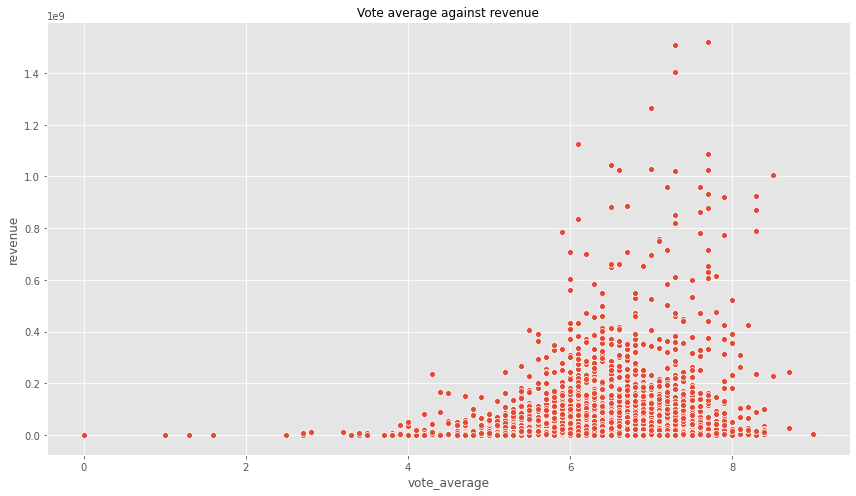

In [53]:
sns.scatterplot(movies.vote_average, movies.revenue)
plt.title('Vote average against revenue')
plt.show()

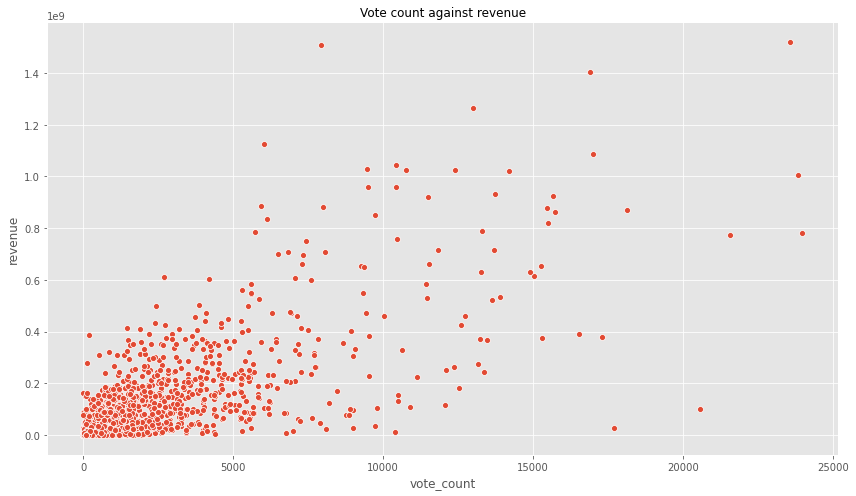

In [52]:
sns.scatterplot(movies.vote_count, movies.revenue)
plt.title('Vote count against revenue')
plt.show()

In [ ]:
movies.to_csv('movis_backup.csv')

In [54]:
movies = pd.read_csv('../input/movies-backup-1/movies_backup (1).csv')

В столбцы cast и crew после парсинга добавились дополнительные признаки, а именно popularity для каждого из членов съемочной группы или актеров. Вероятнее всего это будут очень хорошие признаки для нашей модели:

In [ ]:
movies['sum_popularity_cast'] = movies['cast'].apply(lambda x: sum([eval(x)[i]['popularity'] for i in range(len(eval(x))) if 'popularity' in eval(x)[i]]))
movies['size_cast'] = movies['cast'].apply(lambda x: len(eval(x)))

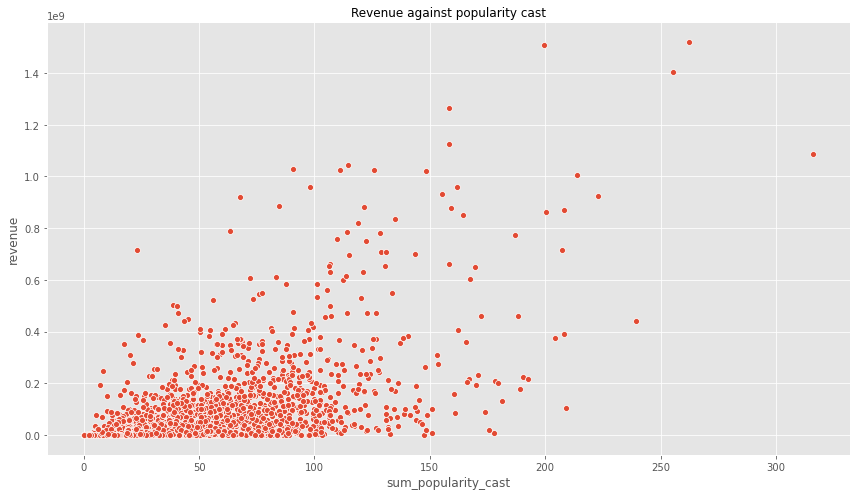

In [57]:
sns.scatterplot(movies.sum_popularity_cast, movies.revenue)
plt.title('Revenue against popularity cast')
plt.show()

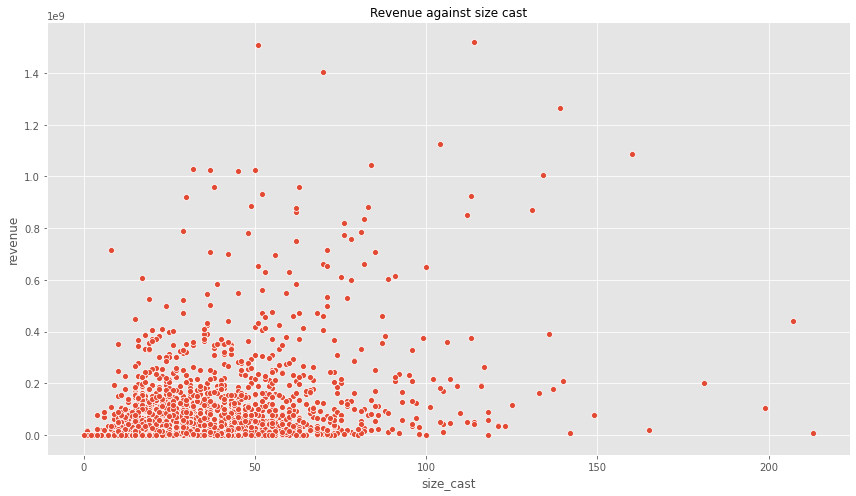

In [58]:
sns.scatterplot(movies.size_cast, movies.revenue)
plt.title('Revenue against size cast')
plt.show()

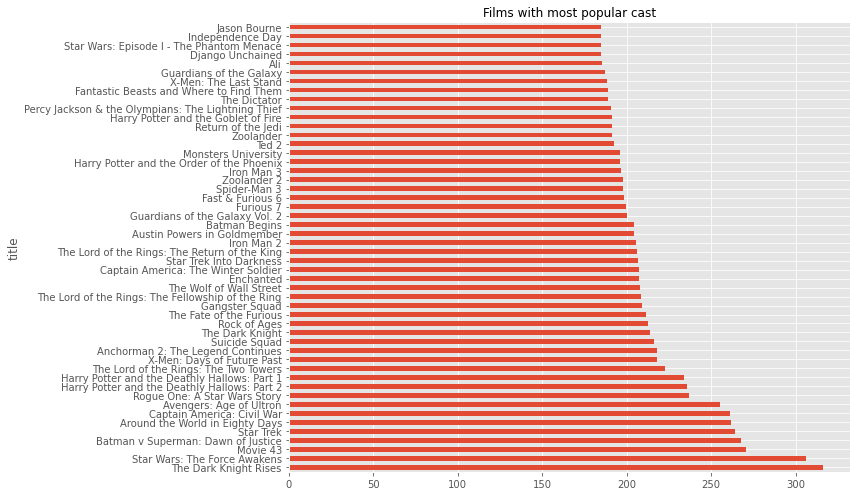

In [60]:
movies.groupby('title').sum_popularity_cast.mean().sort_values(ascending=False).head(50).plot(kind='barh')
plt.title('Films with most popular cast')
plt.show()

Корреляция для среднего значения популярности практически отсутсвует с доходом, лучше уберем этот признак, похоже, что он бестолковый:

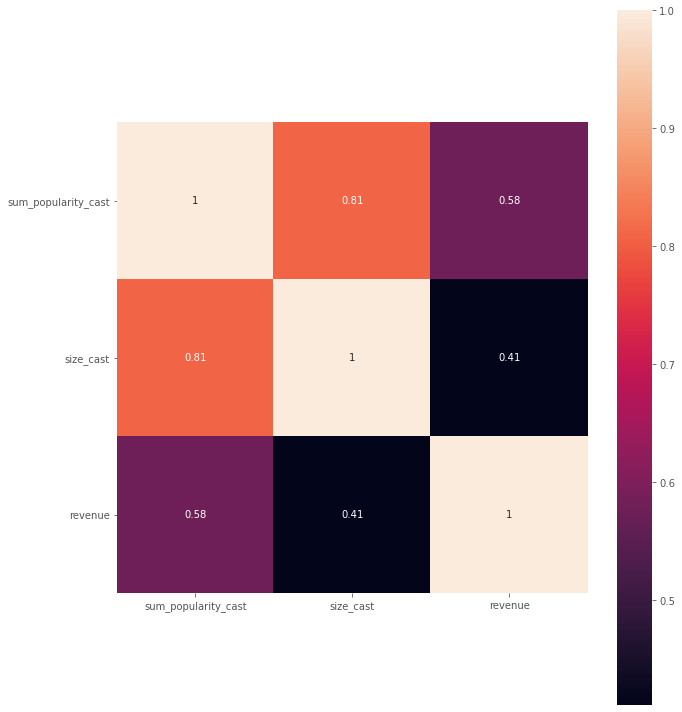

In [63]:
plt.figure(figsize=(10,10))
sns.heatmap(movies[['sum_popularity_cast', 'size_cast', 'revenue']].corr(), annot=True, square=True)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Проделаем те же операции только уже для съемочной группы:

In [ ]:
movies.loc[movies.crew == str({'popularity': 0}), 'crew'] = str([{'popularity': 0}])

In [ ]:
movies['sum_popularity_crew'] = movies['crew'].apply(lambda x: sum(
    [eval(x)[i]['popularity'] for i in range(len(eval(x))) if 'popularity' in eval(x)[i]]))

In [ ]:
movies['size_crew'] = movies['crew'].apply(lambda x: len(eval(x)))

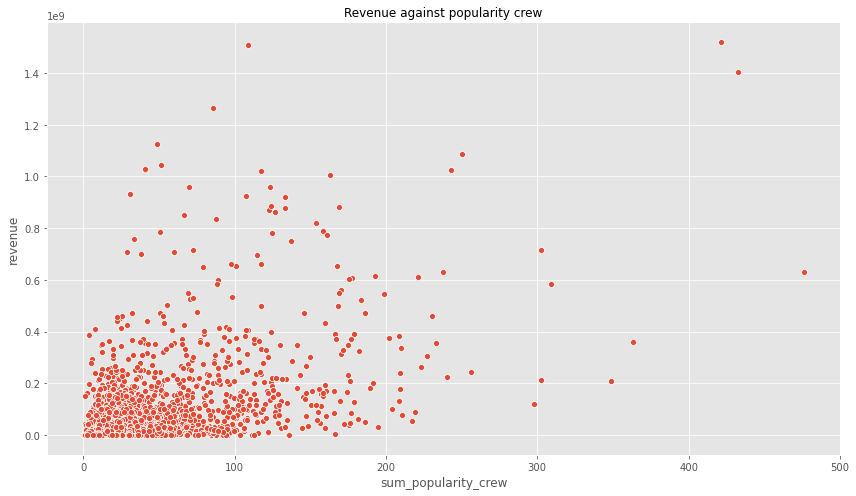

In [65]:
sns.scatterplot(movies.sum_popularity_crew, movies.revenue)
plt.title('Revenue against popularity crew')
plt.show()

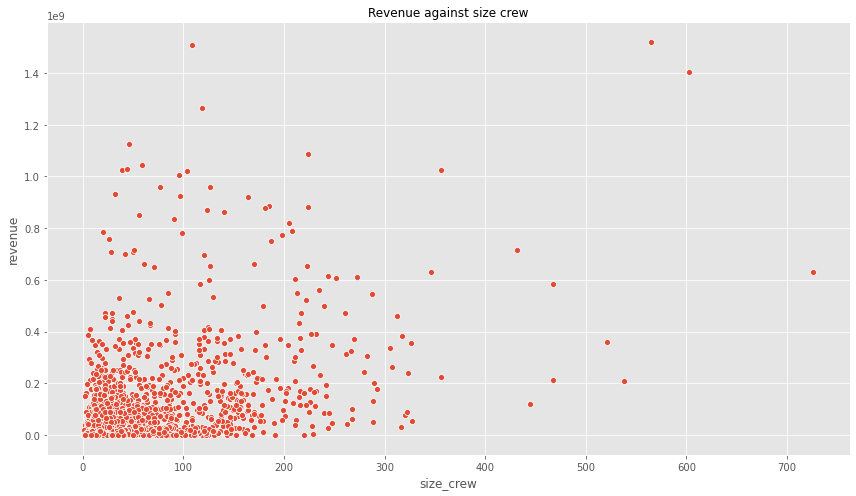

In [64]:
sns.scatterplot(movies.size_crew, movies.revenue)
plt.title('Revenue against size crew')
plt.show()

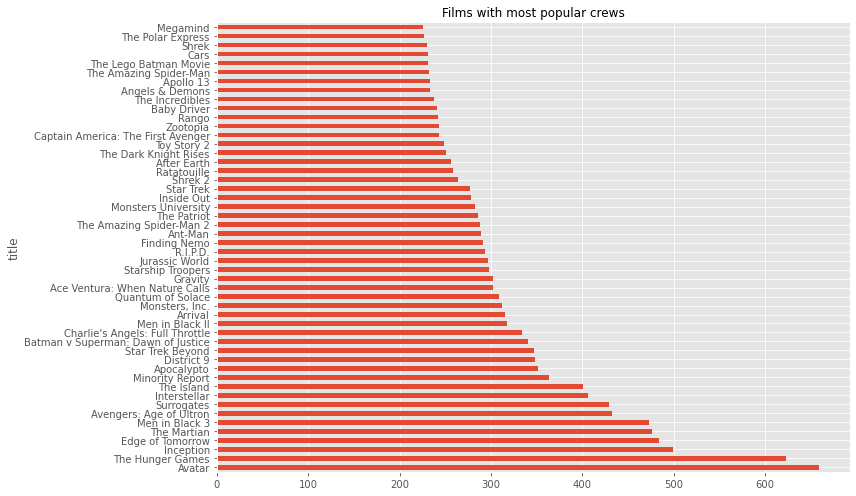

In [67]:
movies.groupby('title').sum_popularity_crew.mean().sort_values(ascending=False).head(50).plot(kind='barh')
plt.title('Films with most popular crews')
plt.show()

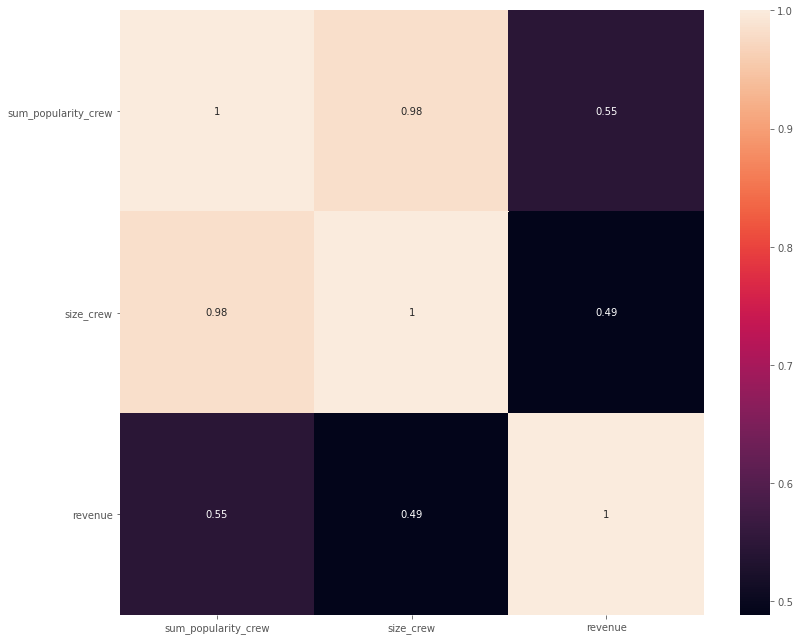

In [68]:
corr_matrix = movies[['sum_popularity_crew', 'size_crew', 'revenue']].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), annot=True)
plt.yticks(rotation=0)
plt.show()

Посмотрим на зависимость дохода от наличия слогана:

In [ ]:
movies.tagline.fillna('', inplace=True)

In [ ]:
movies['have_tagline'] = movies.tagline.apply(lambda x: 0 if x == '' else 1)
movies.groupby('have_tagline', as_index=False).revenue.agg(['mean', 'std'])

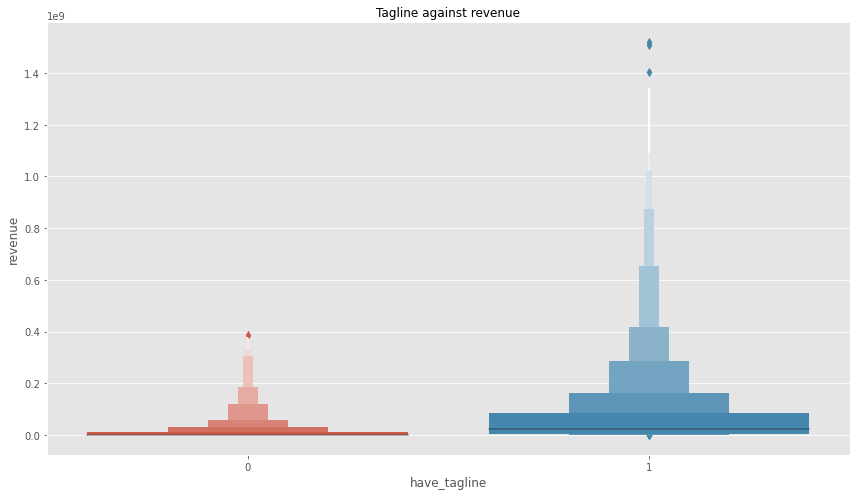

In [70]:
sns.boxenplot(x=movies.have_tagline, y=movies.revenue)
plt.title('Tagline against revenue')
plt.show()

Посмотрим на доход от наличия домашней страницы:

In [ ]:
movies.homepage.fillna('', inplace=True)

In [ ]:
movies['have_homepage'] = movies.homepage.apply(lambda x: 0 if x == '' else 1)
movies.groupby('have_homepage', as_index=False).revenue.agg(['count', 'std'])

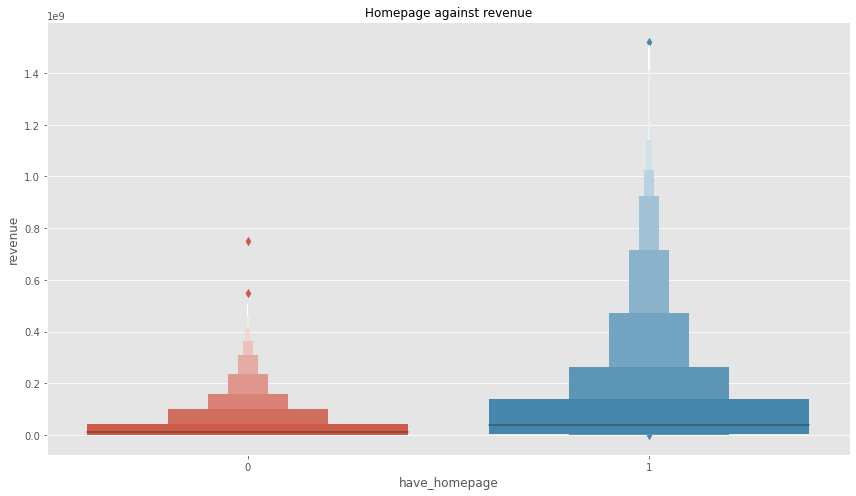

In [71]:
sns.boxenplot(x=movies.have_homepage, y=movies.revenue)
plt.title('Homepage against revenue')
plt.show()

Признак belongs_to_collection - принадлежит ли фильм коллекции, то есть есть ли у него сиквел и является ли он сам сиквелом:

In [ ]:
movies.belongs_to_collection.fillna('None', inplace=True)

In [ ]:
movies['sequel'] = movies.belongs_to_collection.apply(lambda x: 0 if x == 'None' else 1)

In [73]:
movies.groupby('sequel')['revenue'].agg(['mean', 'median'])

,mean,median
sequel,,
0,4.158060e+07,11085509.0
1,1.545084e+08,66001002.0


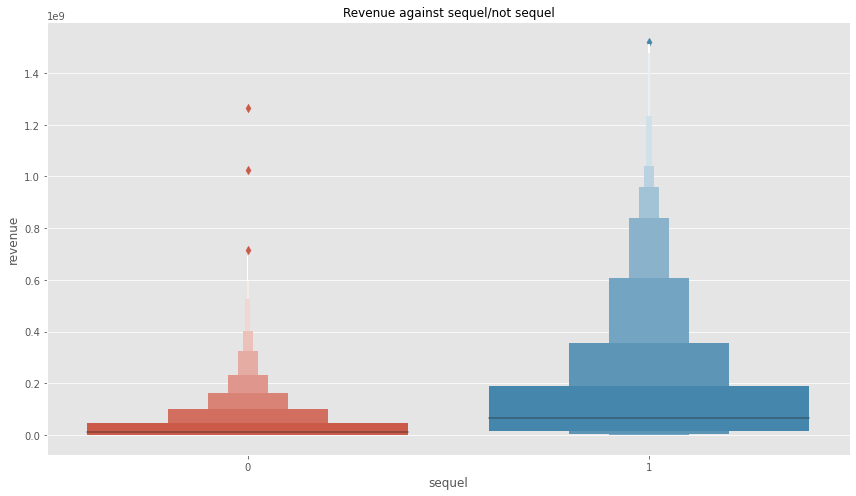

In [74]:
sns.boxenplot(x=movies['sequel'], y=movies['revenue'])
plt.title('Revenue against sequel/not sequel')
plt.show()

Выделим production companies и воспользуемся one-hot encoding-ом для представления данных:

In [ ]:
movies.loc[movies.production_companies.isnull(), 'production_companies'] = 'Without Company'

In [ ]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: ', '.join(sorted([item['name'] for item in eval(x)])))

In [75]:
movies['production_companies']

0          Metro-Goldwyn-Mayer, Paramount, United Artists
1                                  BrownHouse Productions
2       Blumhouse Productions, Bold Films, Right of Wa...
3       Boundscript Motion Pictures, Viacom 18 Motion ...
4                      CJ Entertainment, Realies Pictures
                              ...                        
7393    Di Novi Pictures, Epsilon Motion Pictures, Hyd...
7394                          De Line Pictures, Paramount
7395                                     20th Century Fox
7396    Animal Kingdom, Northern Lights Films, Two Flints
7397     Les Films de la Pléiade, Pathé Consortium Cinéma
Name: production_companies, Length: 7398, dtype: object

In [77]:
movies_production_companies = movies['production_companies'].str.get_dummies(sep=', ')

Посмотрим на компании в разрезе количества произведенных фильмов:

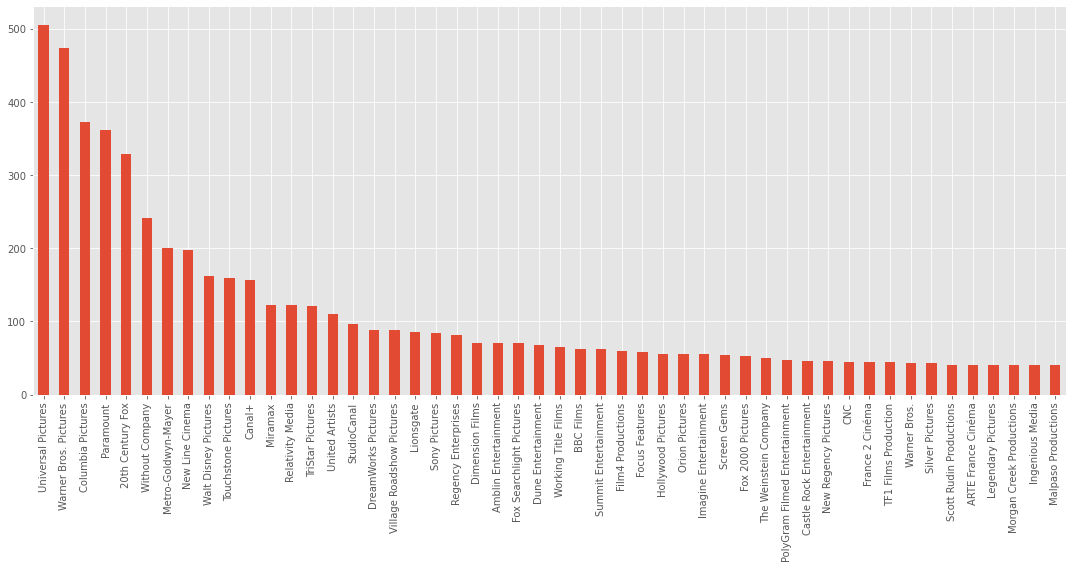

In [78]:
movies_production_companies.sum().sort_values(ascending=False).head(50).plot(kind='bar', figsize=(15,8))

In [79]:
best_production_companies = movies_production_companies.sum().sort_values(ascending=False).head(30).index

In [80]:
movies_production_companies.shape

(7398, 7426)

In [81]:
not_best_production_companies = set(movies_production_companies.columns) - set(best_production_companies)

In [82]:
nbpc = movies_production_companies[not_best_production_companies]

In [83]:
nbpc

,Feuer and Martin Production,Pan Productions,Joanna Productions,Starburns Industries,Betsy's Wedding,Screen Queensland,Stereo D,Soandbrad,Universal International Pictures,Affirm Films,...,DSP,Aramid Entertainment Fund,Kourtrajmé,Adam Fields Productions,Atmosphere Entertainment MM,The Weinstein Company,Yannix Technology Corporation,TSBD Productions,Entertainment One Features,Gladden Entertainment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
n = [1 if sum(nbpc.iloc[ind].values) >= 1 else 0 for ind in nbpc.index]

In [86]:
n = np.array(n)

In [87]:
n = n.reshape(-1, 1)
nbpc = nbpc.assign(Other=n)

In [88]:
movies_production_companies = movies_production_companies[best_production_companies]
movies_production_companies = movies_production_companies.assign(Other=nbpc['Other'])

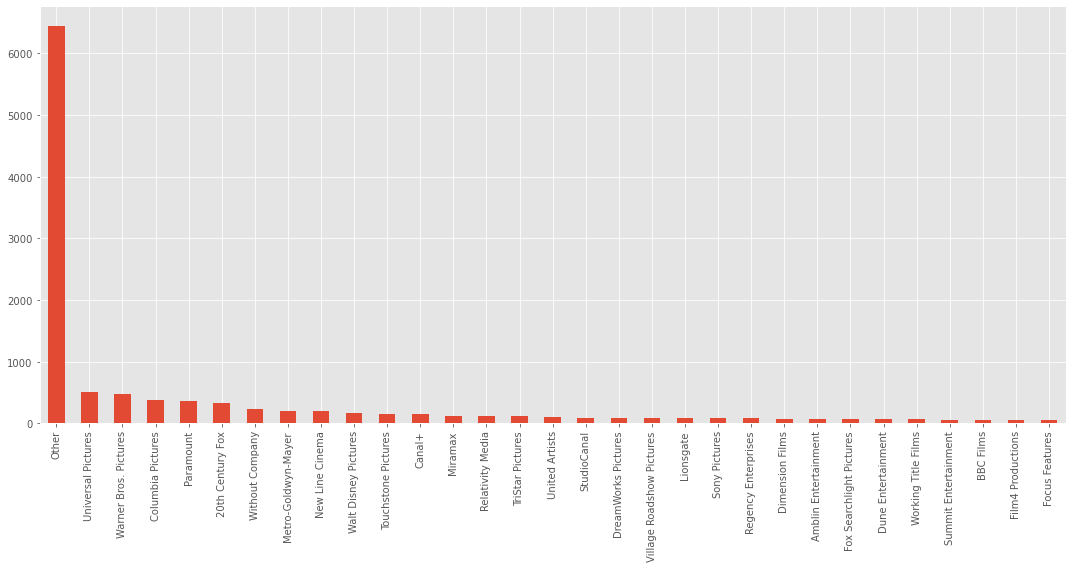

In [89]:
movies_production_companies.sum().sort_values(ascending=False).plot(kind='bar', figsize=(15,8))

In [90]:
movies_production_companies.rename({'Other': 'Other Companies'}, inplace=True)

In [ ]:
movies_production_companies.index = movies.index

In [ ]:
movies = pd.concat([movies, movies_production_companies], axis=1)

Посчитаем количество компаний для каждого фильма:

In [ ]:
movies['count_production_companies'] = movies['production_companies'].apply(lambda x: len(x))

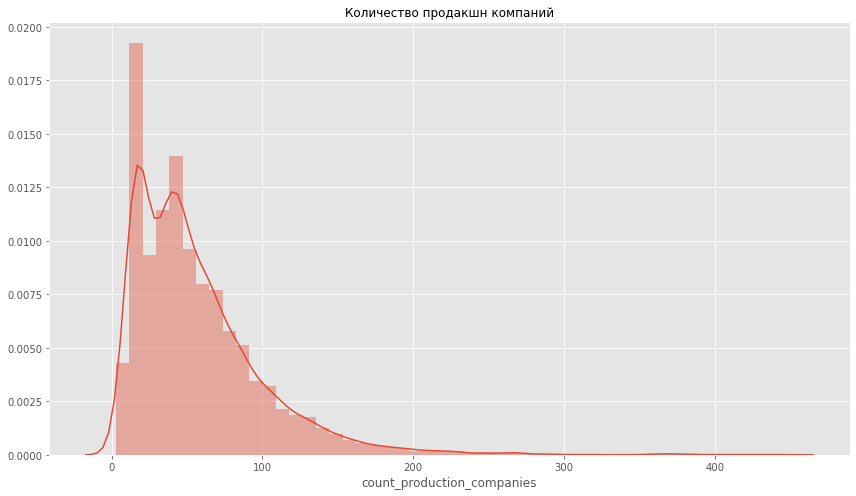

In [94]:
sns.distplot(movies.count_production_companies)
plt.title('Количество продакшн компаний')
plt.show()

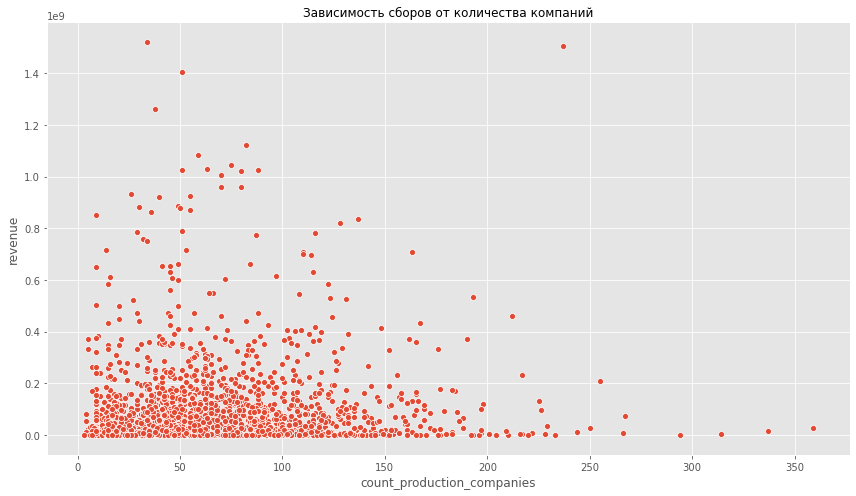

In [95]:
sns.scatterplot(movies.count_production_companies, movies.revenue)
plt.title('Зависимость сборов от количества компаний')
plt.show()

Наиболее популярные страны производства фильмов с точки зрения дохода:

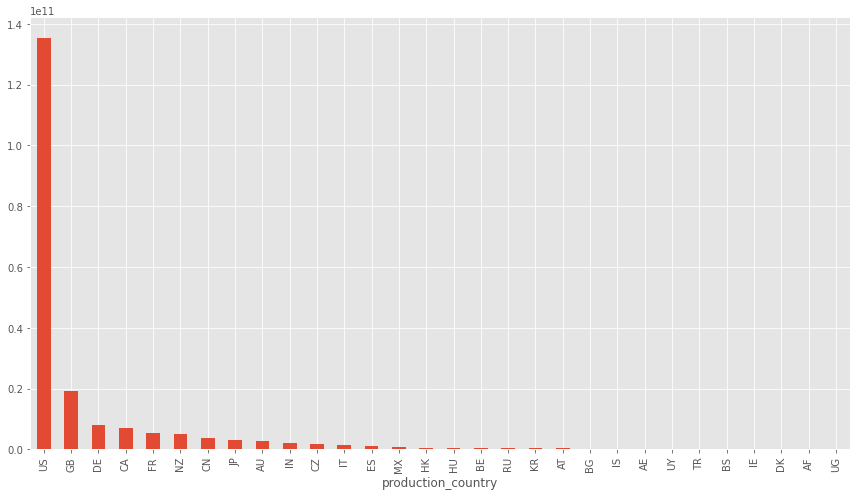

In [96]:
movies.groupby('production_country').revenue.sum().sort_values(ascending=False).head(30).plot(kind='bar')

Представим даты в более удобном для анализа формате:

In [97]:
movies.release_date

0        2/20/15
1         8/6/04
2       10/10/14
3         3/9/12
4         2/5/09
          ...   
7393      8/3/01
7394     8/20/04
7395     12/8/82
7396      2/4/15
7397     9/20/62
Name: release_date, Length: 7398, dtype: object

In [ ]:
dates = movies.release_date.str.split('/').apply(pd.Series) \
    .rename(columns={0: 'month', 1: 'day', 2: 'year'})

In [ ]:
dates = pd.to_datetime(movies.release_date)
movies['day_of_week'] = dates.dt.dayofweek
movies['quarter'] = dates.dt.quarter
movies['year_of_release'] = dates.dt.year

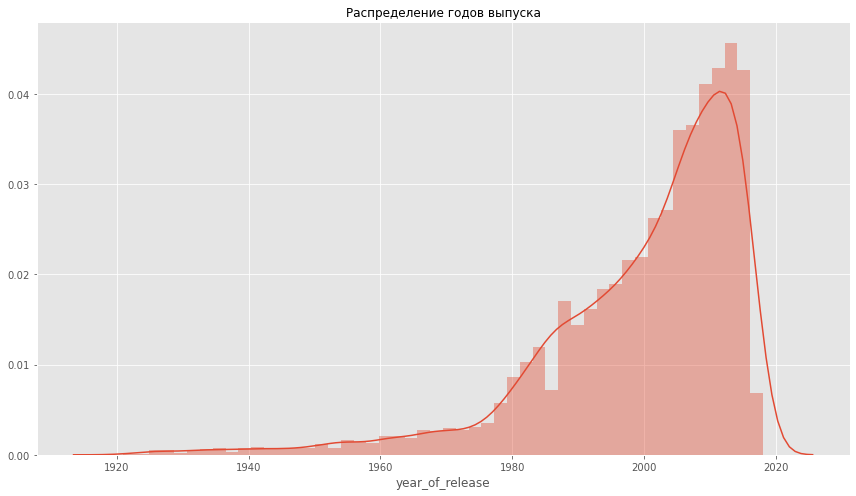

In [98]:
sns.distplot(movies.year_of_release)
plt.title('Распределение годов выпуска')
plt.show()

In [ ]:
movies['year_of_release'] = np.where(movies.year_of_release > 2020, movies.year_of_release - 100, movies.year_of_release)

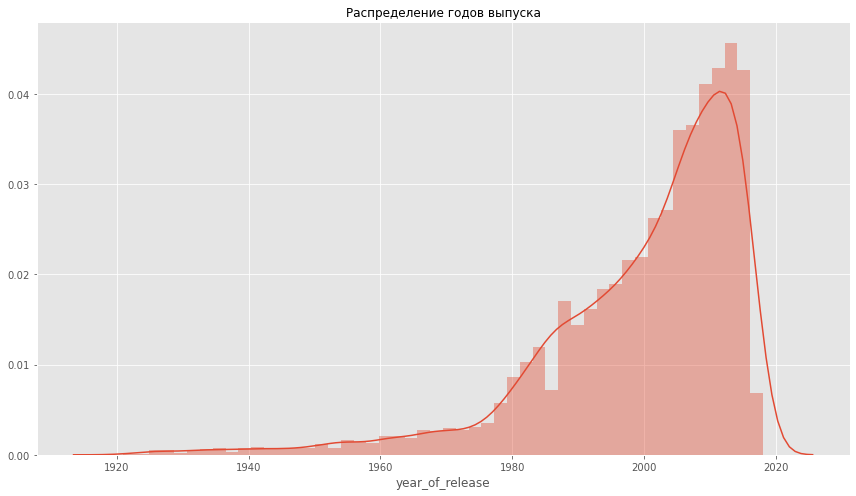

In [99]:
sns.distplot(movies.year_of_release)
plt.title('Распределение годов выпуска')
plt.show()

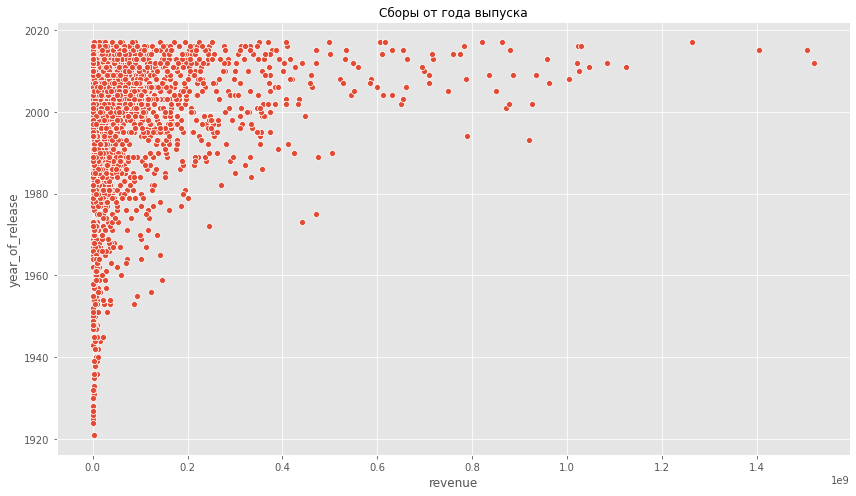

In [100]:
sns.scatterplot(movies.revenue, movies.year_of_release)
plt.title('Сборы от года выпуска')
plt.show()

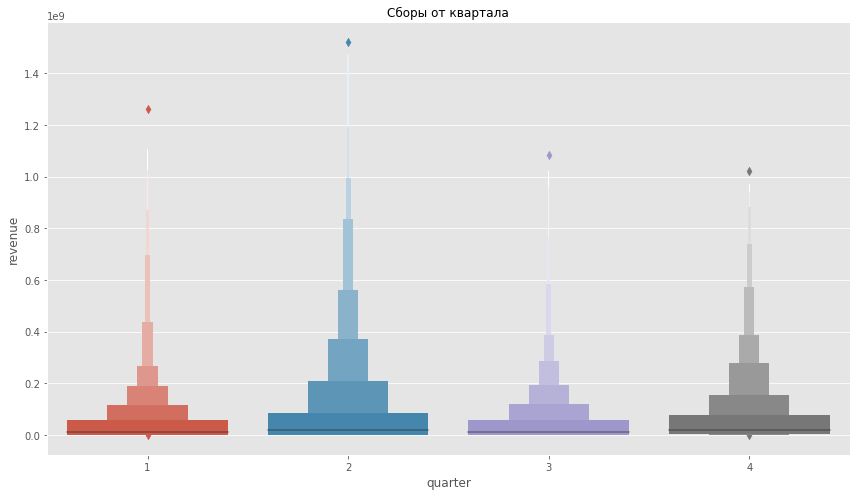

In [101]:
sns.boxenplot(movies.quarter, movies.revenue)
plt.title('Сборы от квартала')
plt.show()

In [102]:
movies.groupby('quarter').revenue.mean()

quarter
1    5.438402e+07
2    9.187719e+07
3    5.229690e+07
4    6.991041e+07
Name: revenue, dtype: float64

In [ ]:
movies['is_second_quater'] = movies.quarter.map({1: 0, 2: 1, 3: 0, 4: 0})

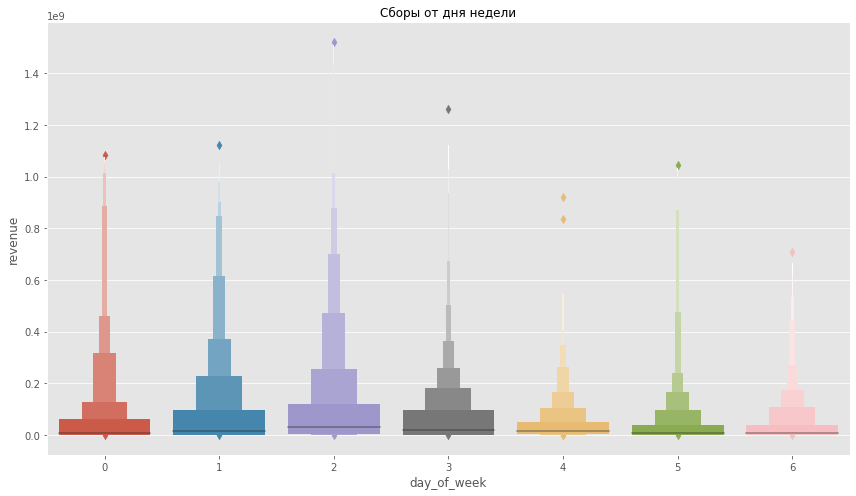

In [104]:
sns.boxenplot(movies.day_of_week, movies.revenue)
plt.title('Сборы от дня недели')
plt.show()

In [105]:
movies.groupby('day_of_week').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
0,135.0,7.517475e+07,1.802894e+08,1.0,639870.50,9114264.0,6.156222e+07,1.084939e+09
1,196.0,9.452430e+07,1.835512e+08,1.0,2350000.00,15196307.5,9.903616e+07,1.123747e+09
2,449.0,1.146446e+08,2.117785e+08,1.0,3903479.00,30399676.0,1.210592e+08,1.519558e+09
3,609.0,7.518481e+07,1.322702e+08,1.0,2450846.00,20300000.0,9.567361e+07,1.262886e+09
4,1334.0,4.577833e+07,8.312892e+07,2.0,3040315.75,15397543.5,4.990590e+07,9.201000e+08
5,158.0,4.907889e+07,1.313842e+08,4.0,746112.00,7950000.0,3.739108e+07,1.045714e+09
6,119.0,4.551647e+07,1.019164e+08,10.0,619751.50,6800000.0,3.931536e+07,7.098275e+08


In [ ]:
movies['third_day_of_week'] = movies['day_of_week'].map({0: 0, 1: 0, 3: 0, 4: 0, 5: 0, 6: 0, 2: 1})

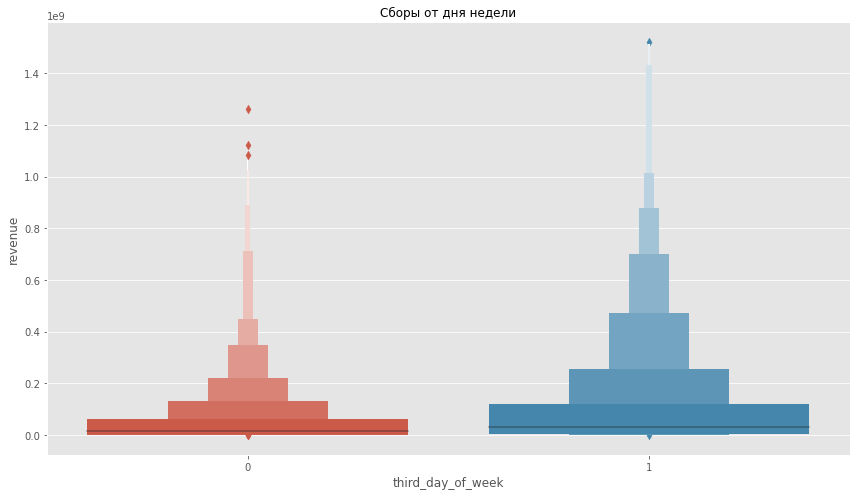

In [106]:
sns.boxenplot(movies.third_day_of_week, movies.revenue)
plt.title('Сборы от дня недели')
plt.show()

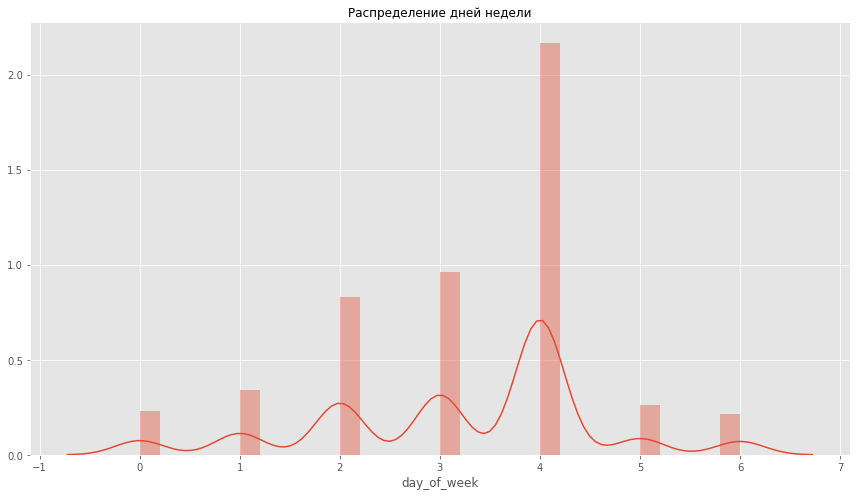

In [114]:
sns.distplot(movies.day_of_week)
plt.title('Распределение дней недели')
plt.show()

- разложить 'spoken_languages', 'cast', 'crew', 'original_language', 'production_country', 'production_companies'

- сделать признак 'have_keywords'

Отберем первые 30 самых популярных языков фильмов:

In [5]:
movies.spoken_languages

0                       en
1                       en
2                       en
3                   en, hi
4                       ko
               ...        
7393    de, en, es, ja, la
7394                    en
7395                    en
7396                    en
7397                    fr
Name: spoken_languages, Length: 7398, dtype: object

In [6]:
movies.loc[movies.spoken_languages.isnull(), 'spoken_languages'] = str([{'iso_639_1': 'undef', 'name': 'Undefined'}])

In [ ]:
movies.loc[~movies.spoken_languages.isnull(), 'spoken_languages'] = movies.loc[~movies.spoken_languages.isnull(), 'spoken_languages'].apply(
    lambda x: ', '.join(sorted([item['iso_639_1'] for item in eval(str(x))])))

In [8]:
movies.loc[movies.spoken_languages.isnull(), 'spoken_languages'] = movies.loc[movies.spoken_languages.isnull(), 'original_language']

In [ ]:
movies_spoken_languages = movies['spoken_languages'].str.get_dummies(', ')

In [ ]:
movies_spoken_languages.sum().sort_values(ascending=False).head(50).plot(kind='bar')

In [116]:
movies_spoken_languages.sum().describe()

NameError: name 'movies_spoken_languages' is not defined

In [ ]:
movies_spoken_languages.sum()[movies_spoken_languages.sum().sort_values(ascending=False) > 23].index

In [ ]:
popular_spoken_languages = movies_spoken_languages.sum()[movies_spoken_languages.sum().sort_values(ascending=False) > 23].index.tolist()

In [ ]:
not_popular_spoken_languages = set(movies_spoken_languages) - set(popular_spoken_languages)

In [ ]:
npsl = movies_spoken_languages[not_popular_spoken_languages]

In [ ]:
npsl.iloc[1]

In [ ]:
npsl.reset_index()

In [ ]:
others_languages = [1 if sum(npsl.iloc[ind].values) >= 1 else 0 for ind in npsl.index]

In [ ]:
movies_spoken_languages = movies_spoken_languages.assign(other=others_languages)

In [ ]:
all_spoken_languages = popular_spoken_languages
all_spoken_languages.append('other')

In [ ]:
movies_spoken_languages = movies_spoken_languages[popular_spoken_languages]

In [ ]:
renamed_columns_lang = {name: name + '_spoken_language' for name in movies_spoken_languages.columns}

In [ ]:
movies_spoken_languages.rename(columns=renamed_columns_lang, inplace=True)

In [ ]:
movies = pd.concat([movies, movies_spoken_languages], axis=1)

Посмотрим более подробнее на признак crew:

In [10]:
producer = movies['crew'].apply(lambda x: ', '.join(sorted([val['name'] for val in eval(x) if 'job' in val and val['job'] == 'Producer'])))

In [11]:
producer = producer.str.get_dummies(', ')

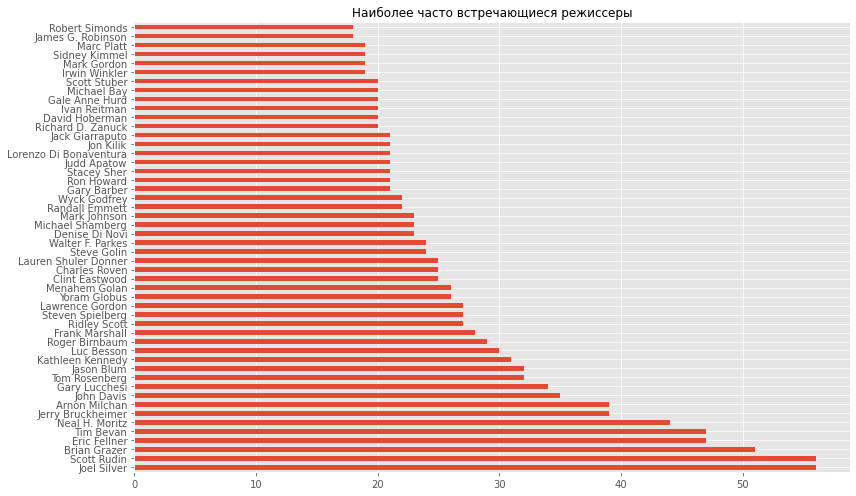

In [13]:
producer.sum().sort_values(ascending=False).head(50).plot(kind='barh')
plt.title('Наиболее часто встречающиеся режиссеры')
plt.show()

In [25]:
producer.pop('revenue')
producer.pop('budget')

0       14000000
1       40000000
2        3300000
3        1200000
4              0
          ...   
7393    42000000
7394    19000000
7395    16000000
7396     2000000
7397       64000
Name: budget, Length: 7398, dtype: int64

In [26]:
producers = list(producer.columns)
#producers.pop('revenue')

In [28]:
producer['revenue'] = movies.revenue
producer['budget'] = movies.budget

In [23]:
info_revenue = producer[['Luc Besson', 'revenue', 'budget']].groupby('Luc Besson')['revenue', 'budget'].agg(['sum', 'mean', 'max'])
info_revenue

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


revenue                                    budget  \
                     sum          mean           max           sum   
Luc Besson                                                           
0           1.995418e+11  6.682580e+07  1.519558e+09  166250612988   
1           6.357294e+08  4.540924e+07  9.002429e+07     954971676   

                                     
                    mean        max  
Luc Besson                           
0           2.256387e+07  380000000  
1           3.183239e+07  197471676

In [29]:
producers_data = {}

for man in producers:
    summary_producers = producer[[man, 'revenue', 'budget']].groupby(man)['revenue', 'budget'].agg(['sum', 'mean', 'max'])
    if 1 in info_revenue.index:
        sum_revenue = summary_producers.iloc[1]['revenue']['sum']
        mean_revenue = summary_producers.iloc[1]['revenue']['mean']
        max_revenue = summary_producers.iloc[1]['revenue']['max']
        sum_budget = summary_producers.iloc[1]['budget']['sum']
        mean_budget = summary_producers.iloc[1]['budget']['mean']
        max_budget = summary_producers.iloc[1]['budget']['max']
        producers_data[man] = [sum_revenue, mean_revenue, max_revenue, sum_budget, mean_budget, max_budget]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [30]:
producers_data = pd.DataFrame.from_dict(producers_data, orient='index')

In [31]:
producers_data.rename(columns={0: 'sum_revenue', 1: 'mean_revenue', 2: 'max_revenue'}, inplace=True)
producers_data.rename(columns={3: 'sum_budget', 4: 'mean_budget', 5: 'max_budget'}, inplace=True)

In [32]:
producers_data

,sum_revenue,mean_revenue,max_revenue,sum_budget,mean_budget,max_budget
50 Cent,7625137.0,3.812568e+06,5496951.0,67220000.0,2.240667e+07,27220000.0
A. Kitman Ho,0.0,NaN,NaN,213500000.0,3.050000e+07,50000000.0
A. M. Rathnam,21500000.0,1.075000e+07,21000000.0,17600000.0,5.866667e+06,9200000.0
A. V. M. Saravanan,37000000.0,1.850000e+07,19000000.0,15230939.0,7.615470e+06,12000000.0
A.J. Dix,96474106.0,3.215804e+07,96060858.0,78000000.0,1.560000e+07,30000000.0
...,...,...,...,...,...,...
Étienne Comar,0.0,NaN,NaN,4000000.0,1.333333e+06,4000000.0
Óscar Guarido,0.0,NaN,NaN,0.0,0.000000e+00,0.0
Şahan Gökbakar,149521495.0,1.495215e+08,149521495.0,0.0,0.000000e+00,0.0
Михаил Розенцвейг,123182.0,1.231820e+05,123182.0,0.0,0.000000e+00,0.0


In [33]:
names_best_producers = []

for feature in producers_data.columns:
    names_best_producers.extend(producers_data[producers_data[feature] > np.quantile(producers_data[~producers_data[feature].isnull()][feature], .95)].index.tolist())

In [34]:
names_best_producers = set(names_best_producers)

In [36]:
best_producers = producer[names_best_producers]

In [37]:
best_producers['have_best_producer'] = [1 if sum(best_producers.iloc[ind]) > 0 else 0 for ind in best_producers.index]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
movies['have_best_producer'] = best_producers['have_best_producer']

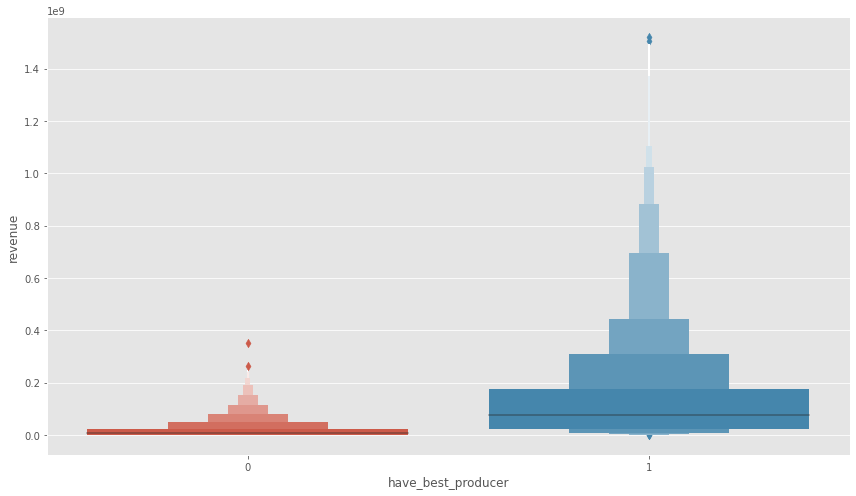

In [39]:
sns.boxenplot(x=movies['have_best_producer'], y=movies['revenue'])

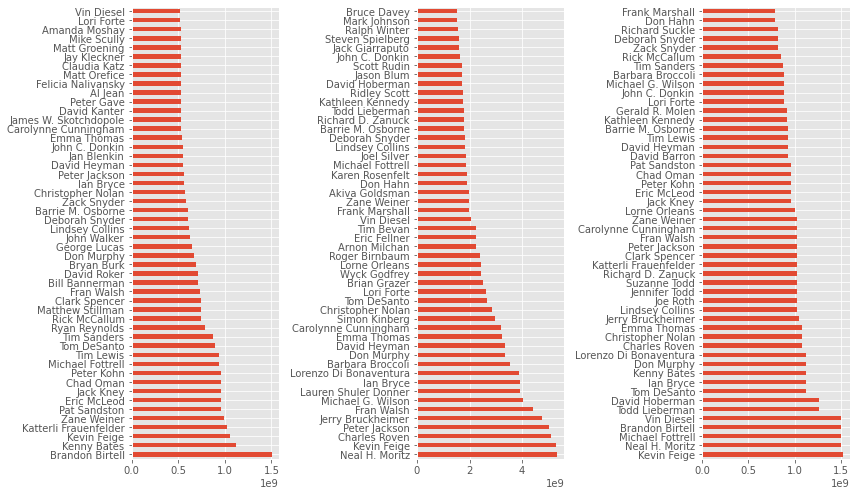

In [43]:
fig, axes = plt.subplots(ncols=3, nrows=1)

producers_data.sort_values(by='mean_revenue', ascending=False)['mean_revenue'].head(50).plot(kind='barh', ax=axes[0], label='mean revenue')

producers_data.sort_values(by='sum_revenue', ascending=False)['sum_revenue'].head(50).plot(kind='barh', ax=axes[1], label='sum revenue')

producers_data.sort_values(by='max_revenue', ascending=False)['max_revenue'].head(50).plot(kind='barh', ax=axes[2], label='max revenue')

Посчитаем budget с учетом инфляции:

In [119]:
movies.revenue.describe()

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64

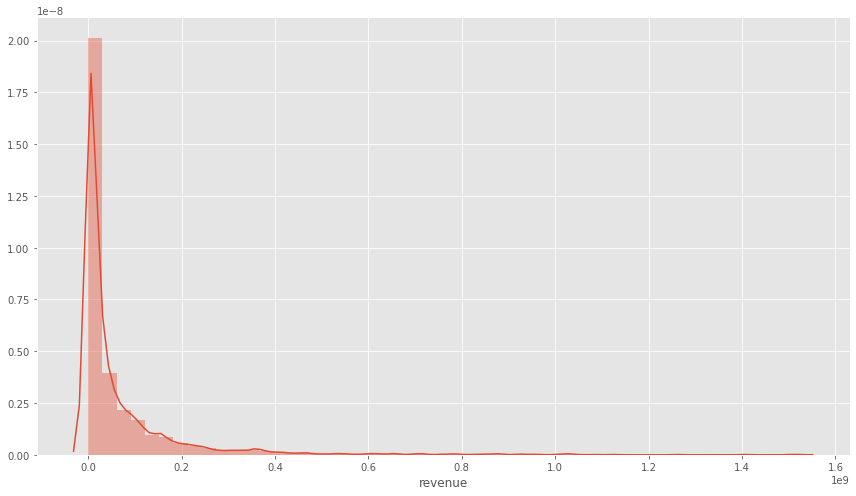

In [120]:
sns.distplot(movies[~movies.revenue.isnull()].revenue + 0.01)

Посчитаем бюджет фильма с учетом инфляции:

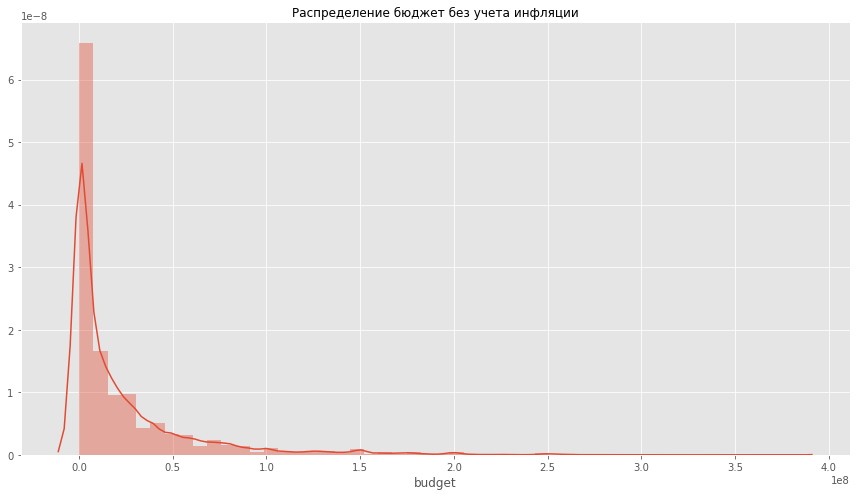

In [121]:
sns.distplot(movies.budget)
plt.title('Распределение бюджет без учета инфляции')
plt.show()

In [ ]:
movies['inflation_budget'] = movies.budget * (1 + 0.0166) ** (2018 - movies.year_of_release)

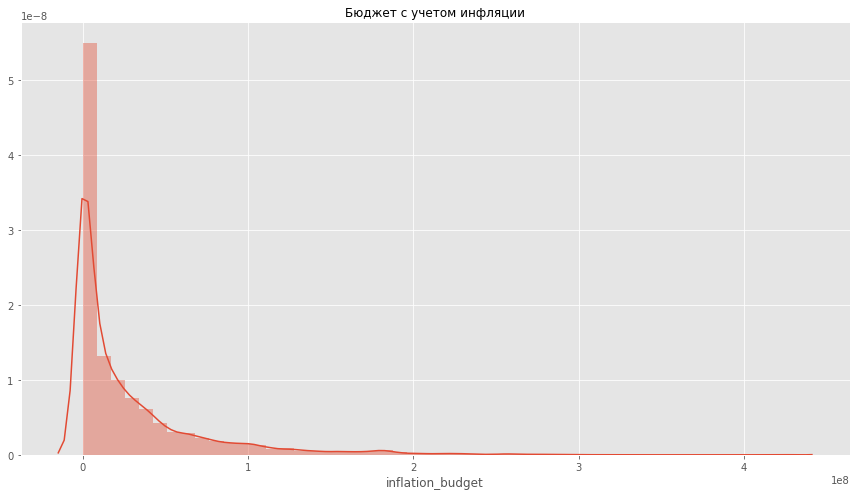

In [122]:
sns.distplot(movies['inflation_budget'])
plt.title('Бюджет с учетом инфляции')
plt.show()

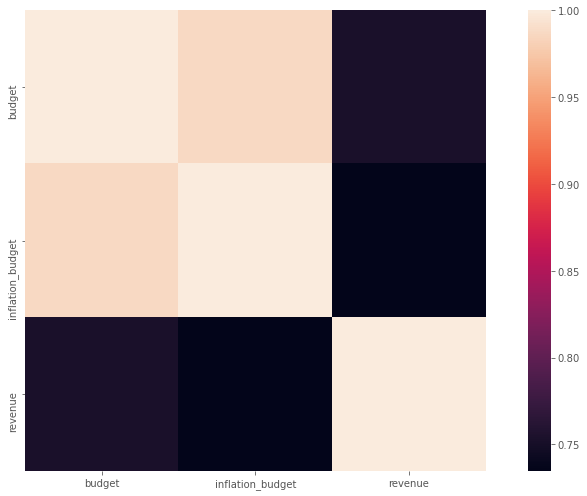

In [126]:
sns.heatmap(movies[['budget', 'inflation_budget', 'revenue']].corr(), square=True)
plt.show()

In [127]:
movies[['budget', 'inflation_budget']].describe()

,budget,inflation_budget
count,7.398000e+03,7.398000e+03
mean,2.260146e+07,2.827104e+07
std,3.694867e+07,4.378702e+07
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,7.500000e+06,1.049397e+07
75%,2.800000e+07,3.704331e+07
max,3.800000e+08,4.264168e+08


In [130]:
movies.isnull().sum().sort_values()

Unnamed: 0.1                   0
Dune Entertainment             0
Fox Searchlight Pictures       0
Amblin Entertainment           0
Dimension Films                0
                            ... 
production_country            95
Keywords                     484
tagline                     1248
revenue                     4398
homepage                    4950
Length: 115, dtype: int64

In [ ]:
movies.to_csv('movies_backup.csv')

In [48]:
movies_for_lr = movies.copy()

In [49]:
movies_for_lr.drop(columns=['Unnamed: 0.1', 'id', 'original_language', 'homepage', 'imdb_id', 'belongs_to_collection',
                     'original_title', 'overview', 'production_companies', 
                     'release_date', 'tagline', 'spoken_languages', 'title',
                    'Keywords', 'cast', 'crew', 
                     'production_country'], inplace=True)

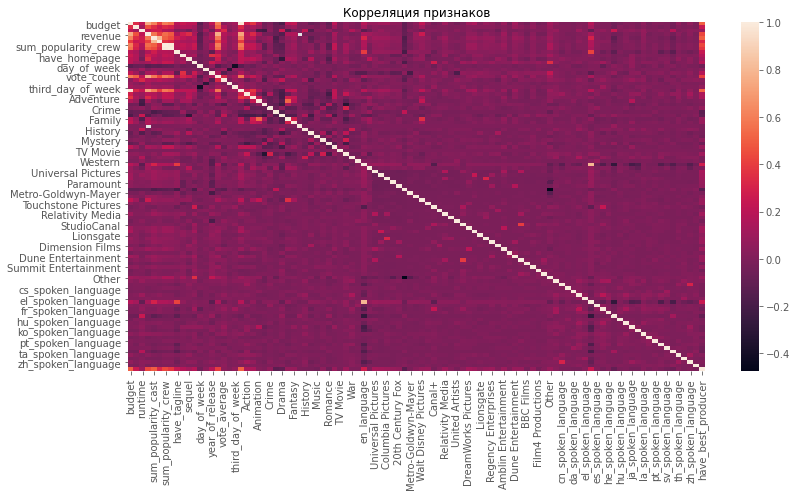

In [55]:
sns.heatmap(movies_for_lr.corr())
plt.title('Корреляция признаков')
plt.show()

In [59]:
movies_for_lr['log_len_title'] = np.log(movies_for_lr.len_title)
movies_for_lr['log_popularity'] = np.log(movies_for_lr.popularity)
movies_for_lr.loc[movies_for_lr.runtime == 0, 'runtime'] = train_data.runtime.median()
movies_for_lr['log_runtime'] = np.log(movies_for_lr.runtime)
movies_for_lr['log_sum_popularity_cast'] = np.log(movies_for_lr.sum_popularity_cast + 1)
movies_for_lr['log_sum_popularity_crew'] = np.log(movies_for_lr.sum_popularity_crew + 1)
movies_for_lr['log_size_cast'] = np.log(movies_for_lr.size_cast + 1)
movies_for_lr['log_size_crew'] = np.log(movies_for_lr.size_crew)
movies_for_lr['log_count_production_companies'] = np.log(movies_for_lr.count_production_companies)
movies_for_lr['log_vote_count'] = np.log(movies_for_lr.vote_count + 1)
movies_for_lr['log_vote_average'] = np.log(movies_for_lr.vote_average + 1)

In [60]:
test_data = movies_for_lr[movies_for_lr.revenue.isnull()]
train_data = movies_for_lr[~movies_for_lr.revenue.isnull()]

In [61]:
test_data.pop('revenue')

3000   NaN
3001   NaN
3002   NaN
3003   NaN
3004   NaN
        ..
7393   NaN
7394   NaN
7395   NaN
7396   NaN
7397   NaN
Name: revenue, Length: 4398, dtype: float64

In [63]:
y = np.array(np.log(train_data.pop('revenue')))
X = np.array(train_data)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [64]:
regressor = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=500)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_val)

mae, r2, msle = mean_absolute_error(np.e**y_pred, np.e**y_val), r2_score(np.e**y_val, np.e**y_pred), mean_squared_log_error(np.e**y_val, np.e**y_pred)
#mae, r2, msle = mean_absolute_error(y_pred, y_val), r2_score(y_val, y_pred), mean_squared_log_error(y_val, y_pred)

In [65]:
print(f'mae = {mae}, r2 = {r2}, msle = {msle}')

mae = 30190759.388292637, r2 = 0.7621124055444586, msle = 4.320430012579928


Посмотрим насколько стабильна ошибка MSLE:

In [67]:
for _ in range(3):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    regressor = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=250)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_val)
    msle = mean_squared_log_error(np.e**y_val, np.e**y_pred)
    print(msle)

3.893389319016838
4.606990308095089
4.7784078391535605


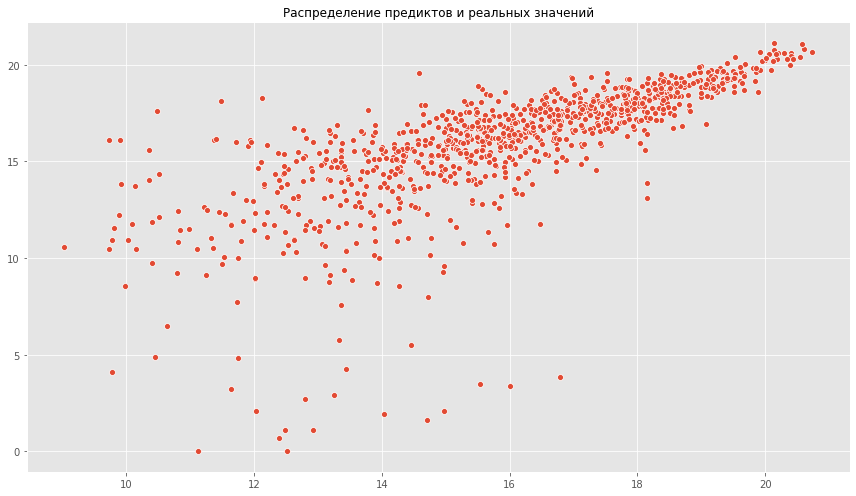

In [68]:
sns.scatterplot(y_pred, y_val)
plt.title('Распределение предиктов и реальных значений')
plt.show()

In [ ]:
X_test = np.array(test_data)
X_test = scaler.transform(X_test)

test_predict = regressor.predict(X_test)

In [ ]:
test_predict = np.e**test_predict

In [ ]:
submission = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')

In [ ]:
submission['revenue'] = test_predict
submission.set_index('id', inplace=True)
submission

In [ ]:
submission.to_csv('submission_log.csv')

In [69]:
feature_importances = dict(zip(train_data.columns, regressor.feature_importances_.astype('float64')))

In [70]:
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

In [73]:
feature_importances_df = pd.DataFrame(feature_importances, columns=['feature', 'coef'])
feature_importances_df

,feature,coef
0,inflation_budget,0.194410
1,vote_count,0.163677
2,log_vote_count,0.142864
3,year_of_release,0.073133
4,popularity,0.041279
...,...,...
103,Amblin Entertainment,0.000018
104,Walt Disney Pictures,0.000016
105,Dune Entertainment,0.000014
106,Foreign,0.000000


In [74]:
feature_importances_df.describe()

,coef
count,108.000000
mean,0.009259
std,0.028655
min,0.000000
25%,0.000304
50%,0.001351
75%,0.005304
max,0.194410


In [75]:
best_columns = feature_importances_df.query('coef > 0.001351')
best_columns = best_columns.feature.values

In [76]:
best_columns

array(['inflation_budget', 'vote_count', 'log_vote_count',
       'year_of_release', 'popularity', 'log_popularity', 'log_runtime',
       'vote_average', 'log_vote_average', 'runtime',
       'sum_popularity_cast', 'log_sum_popularity_cast', 'budget',
       'day_of_week', 'log_count_production_companies',
       'sum_popularity_crew', 'log_sum_popularity_crew', 'len_title',
       'count_production_companies', 'log_len_title', 'size_cast',
       'size_crew', 'log_size_cast', 'log_size_crew',
       'he_spoken_language', 'sequel', 'quarter', 'have_best_producer',
       'en_spoken_language', 'TriStar Pictures', 'sv_spoken_language',
       'en_language', 'have_homepage', 'Western', 'Drama', 'Paramount',
       'Action', 'Crime', 'Thriller', 'other_spoken_language', 'Comedy',
       'Romance', 'fr_spoken_language', 'have_tagline',
       'it_spoken_language', 'Horror', 'ko_spoken_language',
       'Science Fiction', 'is_second_quater', 'cn_spoken_language',
       'Adventure', 'ru_spo

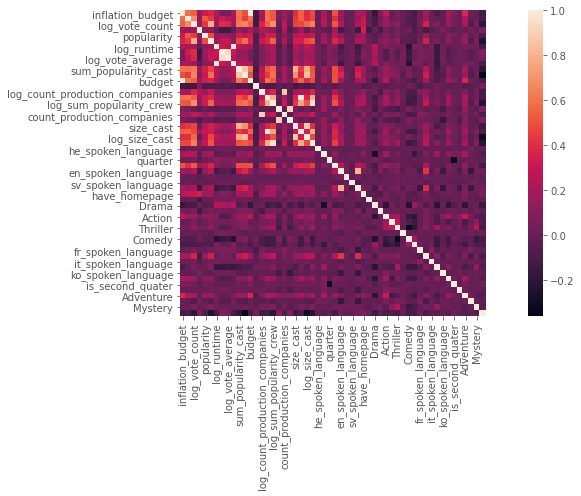

In [78]:
sns.heatmap(movies_for_lr[best_columns].corr(), square=True)
plt.title('Корреляция признаков')
plt.show()

In [79]:
test_data = movies_for_lr[movies_for_lr.revenue.isnull()][best_columns]
train_data = movies_for_lr[~movies_for_lr.revenue.isnull()][best_columns]

In [80]:
X = np.array(train_data)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

regressor = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=500)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_val)

mae, r2, msle = mean_absolute_error(np.e**y_pred, np.e**y_val), r2_score(np.e**y_val, np.e**y_pred), mean_squared_log_error(np.e**y_val, np.e**y_pred)

In [81]:
print(f'mae = {mae}, r2 = {r2}, msle = {msle}')

mae = 30624678.23538415, r2 = 0.7365379494231898, msle = 5.06721215530796


In [82]:
for _ in range(3):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    regressor = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=250)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_val)
    msle = mean_squared_log_error(np.e**y_val, np.e**y_pred)
    print(msle)

4.197593508083955
4.578963001443354
3.8652816421692635


In [ ]:
X_test = np.array(test_data)
X_test = scaler.transform(X_test)

test_predict = regressor.predict(X_test)
test_predict = np.e**test_predict

In [ ]:
submission['revenue'] = test_predict
submission

In [ ]:
submission.to_csv('submission_best_cols_log.csv')

In [83]:
not_log = ['len_title', 'popularity', 'runtime', 'sum_popularity_cast', 'sum_popularity_crew', 'size_cast', 'size_crew', 'count_production_companies', 'vote_count', 'vote_average']
not_log = set(not_log)

In [84]:
movies_columns = set(movies_for_lr.columns)

movies_columns_without_not_log = movies_columns - not_log - set(['revenue'])

In [85]:
movies_columns_without_not_log

{'20th Century Fox',
 'Action',
 'Adventure',
 'Amblin Entertainment',
 'Animation',
 'BBC Films',
 'Canal+',
 'Columbia Pictures',
 'Comedy',
 'Crime',
 'Dimension Films',
 'Documentary',
 'Drama',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'Family',
 'Fantasy',
 'Film4 Productions',
 'Focus Features',
 'Foreign',
 'Fox Searchlight Pictures',
 'History',
 'Horror',
 'Lionsgate',
 'Metro-Goldwyn-Mayer',
 'Miramax',
 'Music',
 'Mystery',
 'New Line Cinema',
 'Other',
 'Paramount',
 'Regency Enterprises',
 'Relativity Media',
 'Romance',
 'Science Fiction',
 'Sony Pictures',
 'StudioCanal',
 'Summit Entertainment',
 'TV Movie',
 'Thriller',
 'Touchstone Pictures',
 'TriStar Pictures',
 'United Artists',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney Pictures',
 'War',
 'Warner Bros. Pictures',
 'Western',
 'Without Company',
 'Working Title Films',
 'ar_spoken_language',
 'budget',
 'cn_spoken_language',
 'cs_spoken_language',
 'da_spoken_language',
 'day_of_week

In [86]:
test_data = movies_for_lr[movies_for_lr.revenue.isnull()][movies_columns_without_not_log]
train_data = movies_for_lr[~movies_for_lr.revenue.isnull()][movies_columns_without_not_log]

In [87]:
X = np.array(train_data)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

regressor = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=500)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_val)

mae, r2, msle = mean_absolute_error(np.e**y_pred, np.e**y_val), r2_score(np.e**y_val, np.e**y_pred), mean_squared_log_error(np.e**y_val, np.e**y_pred)

In [88]:
print(f'mae = {mae}, r2 = {r2}, msle = {msle}')

mae = 29897742.782047972, r2 = 0.7782295530571779, msle = 5.140198829718075


In [89]:
for _ in range(3):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    regressor = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=250)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_val)
    msle = mean_squared_log_error(np.e**y_val, np.e**y_pred)
    print(msle)

4.420315226364257
4.186515432685969
4.471094197513989


In [ ]:
X_test = np.array(test_data)
X_test = scaler.transform(X_test)
test_predict = regressor.predict(X_test)
test_predict = np.e**test_predict
submission['revenue'] = test_predict
submission.to_csv('submission_best_cols_log.csv')

In [90]:
params = {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
clf_pred = clf.predict(X_val)

mae, r2, msle = mean_absolute_error(np.e**clf_pred, np.e**y_val), r2_score(np.e**y_val, np.e**clf_pred), mean_squared_log_error(np.e**y_val, np.e**clf_pred)

In [91]:
print(f'mae = {mae}, r2 = {r2}, msle = {msle}')

mae = 36461723.20801427, r2 = 0.6401152308888465, msle = 4.559319824625371


In [110]:
 clf = GradientBoostingRegressor()

params = {'max_depth': [3, 4, 5, 6, 7], 'learning_rate': [0.1, 0.03, 0.05, 0.07, 0.09, 0.01], 'max_features': [10, 30, 50, 70, 90], 'min_samples_leaf': [1, 2, 3, 4, 5]}
randomized_search_cv = RandomizedSearchCV(clf, params, cv=3, n_jobs=-1, verbose=True)

randomized_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.5s finished


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.03, 0.05, 0.07,
                                                          0.09, 0.01],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': [10, 30, 50, 70, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5]},
                   verbose=True)

In [111]:
randomized_search_cv.best_params_

{'min_samples_leaf': 5,
 'max_features': 90,
 'max_depth': 4,
 'learning_rate': 0.07}

In [113]:
best_clf = randomized_search_cv.best_estimator_

In [115]:
clf_pred = best_clf.predict(X_val)

mae, r2, msle = mean_absolute_error(np.e**clf_pred, np.e**y_val), r2_score(np.e**y_val, np.e**clf_pred), mean_squared_log_error(np.e**y_val, np.e**clf_pred)

In [116]:
print(f'mae = {mae}, r2 = {r2}, msle = {msle}')

mae = 33529257.76348423, r2 = 0.6965571293925481, msle = 4.199754960816292


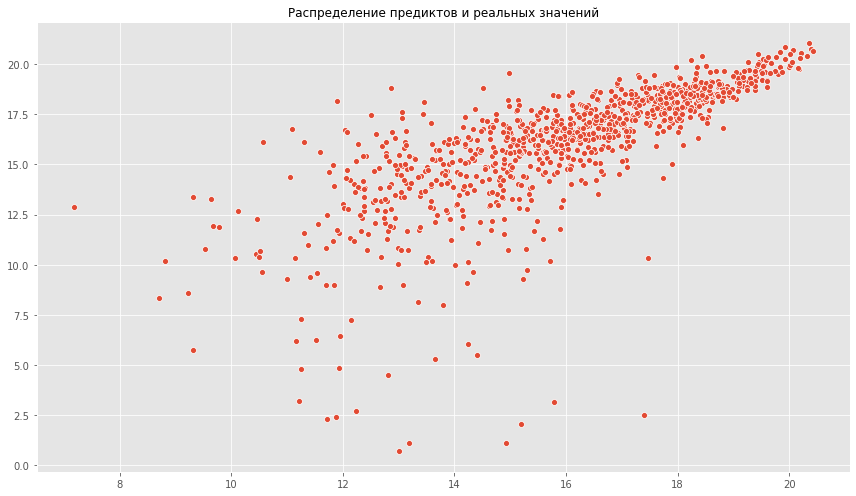

In [117]:
sns.scatterplot(clf_pred, y_val)
plt.title('Распределение предиктов и реальных значений')
plt.show()

Лучшим результатом на отложенном датасете является следующий score (наименьшее значение MSLE):

<img src='https://clip2net.com/clip/m575054/4cffd-clip-29kb.png?nocache=1'>